<a href="https://colab.research.google.com/github/stefanogiagu/corsoinfn/blob/main/notebooks2/Hands_on_2_CNN_su_Acceleratori_FPGA_7_12_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Quantizzazione, compilazione e running su accelratore FPGA del modello CNN addestrato nella sessione hands-on di ieri**

Use case: trigger di alto livello di vertici secondari nello spettrometro muonico dell'esperimento ATLAS

*   compressione del modello addestrato con tensorflow/keras tramite quantizzazione a 8bit con VitisAI
*   compilazione del modello quantizzato per acceleratore Xilinx Alveo U50
*   running del modello e misura delle prestazioni

Referenze: <p>
[Tensorflow Model Optimization](https://www.tensorflow.org/model_optimization/guide) <p>
[VitisAI](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html) <p>

## Quantizzazione con VitisAI

VitisAI richiede Docker e quindi non può essere eseguito su colab

Qui vi faccio vedere il codice necessario ad utilizzarlo e poi lo farò girare su un server ubuntu a Roma in cui è stato installato VitisAI v1.4

istruzioni sull'installazione + un tutorial basato su TF/keras è disponibile sull'area github di VitisAI: [VitiAItuorial](https://github.com/Xilinx/Vitis-AI-Tutorials/blob/1.4/Design_Tutorials/08-tf2_flow/README.md) 

### step 1: quantizzazione del modello con VitisAI

* creare una directory di lavoro *Work*, in cui sarà stato installato VitisAI, e reare lo script shell per eseguire il container docker di VitisAI: *docker_run.sh* disponibile nella cella che segue di questo notebook

* copiare dataset + modello addestrato sull'area lavoro della macchina in cui è installata la scheda acceleratrice FPGA e VitisAI in una directory lavoro (ex. *Work/Test*)

* se necessario (dipende dal sistema operativo e versione di ubuntu installata) abilitare lettura e scrittura sul device grafico associato alla scheda FPGA:


```
sudo chmod o=rw /dev/dri/render*
```


* dalla directory *Work* attivare il container docker di VitisAI: 

```
./docker_run.sh xilinx/vitis-ai-cpu:1.4.1.978
```

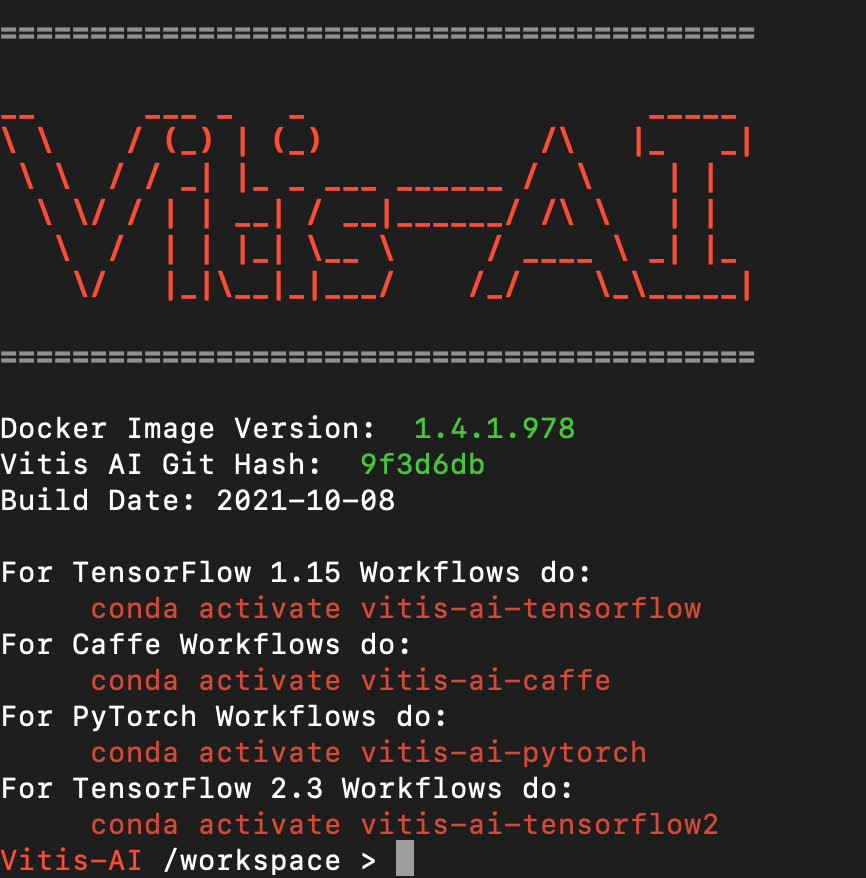

* attivare il setup di VitisAI con backend vs le librerie di Tensorflow 2:

```
conda activate vitis-ai-tensorflow2
```

* quantizzazione fixed-point INT8 fine tuned con VitisAI del modello addestrato:

```
python3 quantize.py --float_model float_model.h5 --quant_model quant_model.h5 --batchsize 64 --evaluate
```

Nello script python viene caricato il dataset, normalizzato in [0,1] e splittato. Viene caricato poi il modello keras float, quantizzato e salvato in un nuovo file .h5. L'opzione di comando --evaluate, confronta le prestazioni del modello originale con quello quantizzato.

In [ ]:
# Script bash: docker_run.sh


#!/bin/bash
# Copyright 2020 Xilinx Inc.

sed -n '1, 5p' ./Vitis-AI/setup/docker/docker/PROMPT.txt
read -n 1 -s -r -p "Press any key to continue..." key

sed -n '5, 15p' ./Vitis-AI/setup/docker/docker/PROMPT.txt
read -n 1 -s -r -p "Press any key to continue..." key

sed -n '15, 28p' ./Vitis-AI/setup/docker/docker/PROMPT.txt
read -n 1 -s -r -p "Press any key to continue..." key

sed -n '28, 61p' ./Vitis-AI/setup/docker/docker/PROMPT.txt
read -n 1 -s -r -p "Press any key to continue..." key

sed -n '62, 224p' ./Vitis-AI/setup/docker/docker/PROMPT.txt
read -n 1 -s -r -p "Press any key to continue..." key

sed -n '224, 308p' ./Vitis-AI/setup/docker/docker/PROMPT.txt
read -n 1 -s -r -p "Press any key to continue..." key


confirm() {
  echo -en "\n\nDo you agree to the terms and wish to proceed [y/n]? "
  read REPLY
  case $REPLY in
    [Yy]) ;;
    [Nn]) exit 0 ;;
    *) confirm ;;
  esac
    REPLY=''
}

confirm


if [[ "$1" == "-h" || "$1" == "--help" ]]; then
    echo "Usage: $0 <image>"
    exit 2
fi

HERE=$(pwd -P) # Absolute path of current directory
user=`whoami`
uid=`id -u`
gid=`id -g`

DOCKER_REPO="xilinx/"

BRAND=vitis-ai
VERSION=latest

CPU_IMAGE_TAG=${DOCKER_REPO}${BRAND}-cpu:${VERSION}
GPU_IMAGE_TAG=${DOCKER_REPO}${BRAND}-gpu:${VERSION}
IMAGE_NAME="${1:-$CPU_IMAGE_TAG}"
DEFAULT_COMMAND="bash"

if [[ $# -gt 0 ]]; then
  shift 1;
  DEFAULT_COMMAND="$@"
  if [[ -z "$1" ]]; then
    DEFAULT_COMMAND="bash"
  fi
fi

DETACHED="-it"

xclmgmt_driver="$(find /dev -name xclmgmt\*)"
docker_devices=""
for i in ${xclmgmt_driver} ;
do
  docker_devices+="--device=$i "
done

render_driver="$(find /dev/dri -name renderD\*)"
for i in ${render_driver} ;
do
  docker_devices+="--device=$i "
done

DOCKER_RUN_DIR="$( cd "$( dirname "${BASH_SOURCE[0]}" )" >/dev/null 2>&1 && pwd )"
if [ "$PWD" != "$DOCKER_RUN_DIR" ]; then
  echo "WARNING: Please start 'docker_run.sh' from the Vitis-AI/ source directory";
fi

docker_run_params=$(cat <<-END
    -v /dev/shm:/dev/shm \
    -v /opt/xilinx/dsa:/opt/xilinx/dsa \
    -v /opt/xilinx/overlaybins:/opt/xilinx/overlaybins \
    -v /etc/xbutler:/etc/xbutler \
    -e USER=$user -e UID=$uid -e GID=$gid \
    -e VERSION=$VERSION \
    -v $DOCKER_RUN_DIR:/vitis_ai_home \
    -v $HERE:/workspace \
    -w /workspace \
    --rm \
    --network=host \
    ${DETACHED} \
    ${RUN_MODE} \
    $IMAGE_NAME \
    $DEFAULT_COMMAND
END
)

##############################

if [[ $IMAGE_NAME == *"gpu"* ]]; then
  docker run \
    $docker_devices \
    --gpus all \
    $docker_run_params
else
  docker run \
    $docker_devices \
    $docker_run_params
fi

In [ ]:
# script python: quantize.py

import argparse
import os
import shutil
import sys
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
from tensorflow_model_optimization.quantization.keras import vitis_quantize
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

physical_devices = tf.config.list_physical_devices('CPU')
print(physical_devices)
print(tf.__version__)
print(tf.keras.__version__)

gpus = tf.config.list_physical_devices('CPU')

DIVIDER = '-----------------------------------------'

def quant_model(float_model,quant_model,batchsize,evaluate):
    '''
    Quantize the floating-point model
    Save to HDF5 file
    '''

    from tensorflow import keras
    tf.test.gpu_device_name()

    fil = np.load('MS_vertex_10_v3.npz')
    labels = fil['labels']
    data_reso = fil['data_reso']
    lr = labels[:,0]
    data_noise = fil['data_noise']

    print(data_noise.shape)
    print(lr.shape)
    print(DIVIDER)
    print('Split and Normalize dataset')

    train_to_test_ratio = 0.8
    X_train,X_test,Y_train,Y_test = train_test_split(data_noise,lr,train_size=train_to_test_ratio, shuffle=True, random_state=1234)

    #normalize
    maxv = np.max(X_train)
    X_train = X_train/maxv
    X_test = X_test/maxv
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    print(DIVIDER)
    X_train = X_train.reshape((X_train.shape[0], 20, 333,1))

    # load the floating point trained model
    f_model = load_model(float_model)

    quant_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    quant_dataset = quant_dataset.shuffle(X_train.shape[0]).batch(batchsize)

    # run quantization
    quantizer = vitis_quantize.VitisQuantizer(f_model)
    quantized_model = quantizer.quantize_model(calib_dataset=quant_dataset)
    # saved quantized model
    quantized_model.summary()
    quantized_model.save(quant_model)
    print('Quantized model saved')



    if (evaluate):
        '''
        Evaluate quantized model
        '''
        print('\n'+DIVIDER)
        print ('Evaluating quantized model..')
        print(DIVIDER+'\n')

        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
        test_dataset = test_dataset.shuffle(X_test.shape[0]).batch(batchsize)

        quantized_model.compile(optimizer=Adam(),
                                loss='mse',
                                metrics=['mae'])

        scores = quantized_model.evaluate(test_dataset,
                                          verbose=1)
        scores_float = f_model.evaluate(test_dataset, verbose=1)
        print('Float model mae: ',scores_float[1])
        print('Quantized model mae: ',scores[1])
        print('\n'+DIVIDER)
        print('Float model scores0: ', scores_float[0])
        print('Quantized model scores0: ', scores[0])
    return



def main():

    # construct the argument parser and parse the arguments
    ap = argparse.ArgumentParser()
    ap.add_argument('-m', '--float_model',  type=str, default='float_model.h5', help='Full path of floating-point model. Default is float_model.h5')
    ap.add_argument('-q', '--quant_model',  type=str, default='quant_model.h5', help='Full path of quantized model. Default is quant_model.h5')
    ap.add_argument('-b', '--batchsize',    type=int, default=64,                       help='Batchsize for quantization. Default is 64')
    ap.add_argument('-e', '--evaluate',     action='store_true', help='Evaluate floating-point model if set. Default is no evaluation.')
    args = ap.parse_args()

    print('\n------------------------------------')
    print('TensorFlow version : ',tf.__version__)
    print(sys.version)
    print('------------------------------------')
    print ('Command line options:')
    print (' --float_model  : ', args.float_model)
    print (' --quant_model  : ', args.quant_model)
    print (' --batchsize    : ', args.batchsize)
    print (' --evaluate     : ', args.evaluate)
    print('------------------------------------\n')


    quant_model(args.float_model, args.quant_model, args.batchsize, args.evaluate)


if __name__ ==  "__main__":
    main()


### step 2: compilazione del modello con VitisAI

* setup della scheda Alveo U50:

```
source setup.sh DPUCAHX8H
```

lo script è disponibile nella cella del notebook che segue. *DPUCAHX8H* indica l'archiettettura della Deep Learning Processor Unit utilizzata dalla scheda U50, in particolare quella utilizzata è ottimizzata per Convolutional Neural Networks (supporta operazioni accelerate di Convoluzione e Deconvoluzione e Max e Average Pooling).


* compilazione del modello:

```
vai_c_tensorflow2 -m modello_quantizzato.h5 -a /opt/vitis_ai/compiler/arch/DPUCAHX8H/U50/arch.json -o /path-files-compilati -n <nome del modello>

#esempio:
vai_c_tensorflow2 -m quant_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCAHX8H/U50/arch.json -o test -n test
```

In [ ]:
# script setup.sh scheda U50:

#!/usr/bin/env bash
# Copyright 2021 Xilinx Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

if [[ "$CONDA_DEFAULT_ENV" = "base" ]]; then
  echo "WARNING: No conda environment has been activated."
fi

if [[ -z $VAI_HOME ]]; then
	export VAI_HOME="$( readlink -f "$( dirname "${BASH_SOURCE[0]}" )/../.." )"
fi

echo "------------------"
echo "VAI_HOME = $VAI_HOME"
echo "------------------"

source /opt/xilinx/xrt/setup.sh
echo "---------------------"
echo "XILINX_XRT = $XILINX_XRT"
echo "---------------------"

source /opt/xilinx/xrm/setup.sh
echo "---------------------"
echo "XILINX_XRM = $XILINX_XRM"
echo "---------------------"

echo "---------------------"
echo "LD_LIBRARY_PATH = $LD_LIBRARY_PATH"
echo "---------------------"

PLATFORMS="u50_ u50lv_ u200_ u250_ u280_"

for platform in ${PLATFORMS};
do
xbutil scan | grep ${platform}
if [ $? -eq 0 ]; then
  echo "${platform} card detected"
  break
fi
done

case $1 in

  DPUCAHX8H | dpuv3e)
    if [ "${platform}" = "u50_" ]; then
      export XCLBIN_PATH=/opt/xilinx/overlaybins/DPUCAHX8H
      export XLNX_VART_FIRMWARE=/opt/xilinx/overlaybins/DPUCAHX8H/dpuv3e_6E300_xilinx_u50_gen3x4_xdma_base_2.xclbin
    elif [ "${platform}" = "u50lv_" ]; then
      export XCLBIN_PATH=/opt/xilinx/overlaybins/DPUCAHX8H
      export XLNX_VART_FIRMWARE=/opt/xilinx/overlaybins/DPUCAHX8H/dpuv3e_10E275_xilinx_u50lv_gen3x4_xdma_base_2.xclbin
    elif [ "${platform}" = "u280_" ]; then
      export XCLBIN_PATH=/opt/xilinx/overlaybins/DPUCAHX8H
      export XLNX_VART_FIRMWARE=/opt/xilinx/overlaybins/DPUCAHX8H/dpuv3e_14E300_xilinx_u280_xdma_201920_3.xclbin
    else
      export XCLBIN_PATH=
      export XLNX_VART_FIRMWARE=
    fi
    ;;

  DPUCAHX8L | dpuv3me)
    if [ "${platform}" = "u50_" ]; then
      export XCLBIN_PATH=/opt/xilinx/overlaybins/DPUCAHX8L
      export XLNX_VART_FIRMWARE=/opt/xilinx/overlaybins/DPUCAHX8L/dpuv3me_1E333_xilinx_u50_gen3x4_xdma_base_2.xclbin
    elif [ "${platform}" = "u50lv_" ]; then
      export XCLBIN_PATH=/opt/xilinx/overlaybins/DPUCAHX8L
      export XLNX_VART_FIRMWARE=/opt/xilinx/overlaybins/DPUCAHX8L/dpuv3me_1E250_xilinx_u50lv_gen3x4_xdma_base_2.xclbin
    elif [ "${platform}" = "u280_" ]; then
      export XCLBIN_PATH=/opt/xilinx/overlaybins/DPUCAHX8L
      export XLNX_VART_FIRMWARE=/opt/xilinx/overlaybins/DPUCAHX8L/dpuv3me_2E250_xilinx_u280_xdma_201920_3.xclbin
    else
      export XCLBIN_PATH=
      export XLNX_VART_FIRMWARE=
    fi
    ;;

  DPUCADF8H | dpuv3int8)
    if [ "${platform}" = "u200_" ]; then
      export XCLBIN_PATH=/opt/xilinx/overlaybins/DPUCADF8H
      export XLNX_VART_FIRMWARE=/opt/xilinx/overlaybins/DPUCADF8H/dpdpuv3_wrapper.hw.xilinx_u200_gen3x16_xdma_1_202110_1.xclbin
    elif [ "${platform}" = "u250_" ]; then
      export XCLBIN_PATH=/opt/xilinx/overlaybins/DPUCADF8H
      export XLNX_VART_FIRMWARE=/opt/xilinx/overlaybins/DPUCADF8H/dpdpuv3_wrapper.hw.xilinx_u250_gen3x16_xdma_3_1_202020_1.xclbin
    else
      export XCLBIN_PATH=
      export XLNX_VART_FIRMWARE=
    fi
    ;;

  *)
    echo "Invalid argument $1!!!!"
    ;;
esac


echo "---------------------"
echo "XCLBIN_PATH = $XCLBIN_PATH"
echo "XLNX_VART_FIRMWARE = $XLNX_VART_FIRMWARE"
echo "---------------------"

### step 3: run modello sulla scheda FPGA

```
python3 app_mt.py -t <numero threads utilizzabili> -m <path modello compilato>

Esempio:

python3 app_mt.py -t 1 -m test/test.xmodel
```

lo script python app_mt.py è disponibile nella cella che segue.

In [ ]:
# script python app_mt.py

from ctypes import *
from typing import List
import cv2
import numpy as np
import vart
import os
import pathlib
import xir
import threading
import time
import sys
import argparse
import json

import shutil
import sys
from sklearn.model_selection import train_test_split


divider = '---------------------'

# funzione che controlla se i subgraph nei quali e' stato rappresentato il modello quantizzato 
# sono disposti correttamente e li ordina dal root ad uscire
def get_child_subgraph_dpu(graph: "Graph") -> List["Subgraph"]:
    assert graph is not None, "'graph' should not be None."
    root_subgraph = graph.get_root_subgraph()
    assert (root_subgraph is not None), "Failed to get root subgraph of input Graph object."
    if root_subgraph.is_leaf:
        return []
    child_subgraphs = root_subgraph.toposort_child_subgraph()
    assert child_subgraphs is not None and len(child_subgraphs) > 0
    return [
        cs
        for cs in child_subgraphs
        if cs.has_attr("device") and cs.get_attr("device").upper() == "DPU"
    ]

# funzione che estrae dal modello compilato i tensori di input, da utilizzare
# per il run su FPGA, e i tensori di output, nei quali storare i risultati 
def runDPU(id,start,dpu,img):

    '''get tensor'''
    inputTensors = dpu.get_input_tensors()
    outputTensors = dpu.get_output_tensors()
    input_ndim = tuple(inputTensors[0].dims)
    output_ndim = tuple(outputTensors[0].dims)

    
    print('Output Tensors len: ', len(outputTensors))
    print('Input ndim: ',input_ndim)  # (3, 20, 333, 1)
    print('Output ndim: ', output_ndim)
    
    #batchSize = 1
    batchSize = input_ndim[0]
    n_of_images = len(img)
    count = 0
    write_index = start
    
    while count < n_of_images:
        if (count+batchSize<=n_of_images):
            runSize = batchSize
        else:
            runSize=n_of_images-count

        '''prepare batch input/output '''
        outputData = []
        inputData = []
        inputData = [np.empty(input_ndim, dtype=np.float32, order="C")]
        outputData = [np.empty(output_ndim, dtype=np.float32, order="C")]
        
        
        '''init input image to input buffer '''
        for j in range(runSize):
            imageRun = inputData[0]
            imageRun[j, ...] = img[(count + j) % n_of_images].reshape(input_ndim[1:])
            '''
            imageRun = inputData[0]
            index = (count+j)%n_of_images
            img2 = img[index]
            imageRun[j, ...] = img2[j].reshape(input_ndim[1:])
            '''
# effettivo run su FPGA, dpu.wait permette di aspettare che venga eseguito 
# un job prima di fare quello dopo
        '''run with batch '''
        job_id = dpu.execute_async(inputData,outputData)
        dpu.wait(job_id)

        '''store output vector'''
        for j in range(runSize):
            out_q[write_index] = outputData[0][j]
            write_index += 1
        count = count + runSize
        '''       
        print(' output Data: ', outputData)
        out_q[0] = outputData[0]
        
        '''
        
        
        
def app(threads,model):

    print('1. Loading datasets')
    fil = np.load('MS_vertex_10_v3.npz')
    labels = fil['labels']
    data_reso = fil['data_reso']
    lr = labels[:,0]
    data_noise = fil['data_noise']

    print(data_noise.shape)
    print(lr.shape)
    
    print('Split and Normalize dataset')

    train_to_test_ratio = 0.8
    X_train,X_test,Y_train,Y_test = train_test_split(data_noise,lr,train_size=train_to_test_ratio, shuffle=True, random_state=1234)

    maxv = np.max(X_train)
    X_train = X_train/maxv
    X_test = X_test/maxv
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    img = []
    for i in range(X_test.shape[0]):
        img.append(X_test[i])
        
    print('runTotal: ', len(img))
    runTotal = len(img)
    '''
    k = 920    
    
    X_test = X_test[k].reshape((1,20,333,1))
    runTotal =  X_test.shape[0]
    
    '''
    global out_q
    out_q = [None] * runTotal 
         
    g = xir.Graph.deserialize(model)
    subgraphs = get_child_subgraph_dpu(g)
    all_dpu_runners = []
    
    for i in range(threads):
        all_dpu_runners.append(vart.Runner.create_runner(subgraphs[0], "run"))
        
   

    
    print('Pre-processing',runTotal,'images...')
   

    '''run threads '''
    print('Starting',threads,'threads...')
    threadAll = []
    start=0
    for i in range(threads):
        if (i==threads-1):
            end = len(img)
        else:
            end = start+(len(img)//threads)
        in_q = img[start:end]
        t1 = threading.Thread(target=runDPU, args=(i,start,all_dpu_runners[i], in_q))
        threadAll.append(t1)
        start=end

    time1 = time.time()
    for x in threadAll:
        x.start()
    for x in threadAll:
        x.join()
    time2 = time.time()
    timetotal = time2 - time1

    fps = float(runTotal / timetotal)
    print("Throughput=%.2f fps, total frames = %.0f, time=%.4f seconds" %(fps, runTotal, timetotal))
    
    ''' post - processing '''
    mse = 0 
    for i in range(len(out_q)):
        prediction = out_q[i][0]        
        ground_truth = Y_test[i]
        mse += (prediction - ground_truth)**2
        
        if i < 10:
            print('Prediction: ', prediction)
            print('Ground tru: ', ground_truth)
            print(divider)
            
    print('mae: ', (mse/len(out_q)))
    
    return


         
def main():
    ap = argparse.ArgumentParser()
    ap.add_argument('-t', '--threads', type = int, default=1, help = 'Number of threads. Default 1.')
    ap.add_argument('-m', '--model', type=str, default='customcnn.xmodel', help='Path of xmodel. Default is customcnn.xmodel')


    args = ap.parse_args()
    
    print(divider)
    print ('Command line options:')
    print (' --threads   : ', args.threads)
    print (' --model     : ', args.model)

    app(args.threads,args.model)

if __name__ == '__main__':
  main()